# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import itertools
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [ ]:
# Define a function to load data and aggregate them

def load_and_aggregate_data(file_paths):
    """
    Load multiple stock CSV files and aggregate them into one df
    """
    dataframes = []

    for name, path in file_paths.items():
        df = pd.read_csv(path)
        df['Name'] = name
        dataframes.append(df)
    combined_df = pd.concat(dataframes, ignore_index=True)

    return combined_df


In [ ]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_paths = {
    "AMZN": "/content/AMZN_stocks_data.csv",
    "GOOGL": "/content/GOOGL_stocks_data.csv",
    "IBM": "/content/IBM_stocks_data.csv",
    "MSFT": "/content/MSFT_stocks_data.csv"
}

stock_data = load_and_aggregate_data(file_paths)



In [ ]:
# View specifics of the data
# View first 5 rows
print(stock_data.head())

# Info about columns, dtypes, nulls
print(stock_data.info())

# Summary statistics
print(stock_data.describe())

# Unique company names
print("Companies in dataset:", stock_data['Name'].unique())

# Check for missing values
print("Missing values per column:\n", stock_data.isnull().sum())



         Date   Open   High    Low  Close   Volume  Name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB
None
               Open          High           Low         Close        Volume
count  12076.000000  12077.000000  12076.000000  12077.000000  1.207700e

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [ ]:
# Handle Missing Values
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
print("Missing values before handling:\n", stock_data.isnull().sum())

stock_data = stock_data.fillna(method='ffill')
stock_data = stock_data.fillna(method='bfill')


print("Missing values after handling:\n", stock_data.isnull().sum())

Missing values before handling:
 Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64
Missing values after handling:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


/tmp/ipython-input-917423364.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill')
/tmp/ipython-input-917423364.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='bfill')


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

/tmp/ipython-input-14867019.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Company")


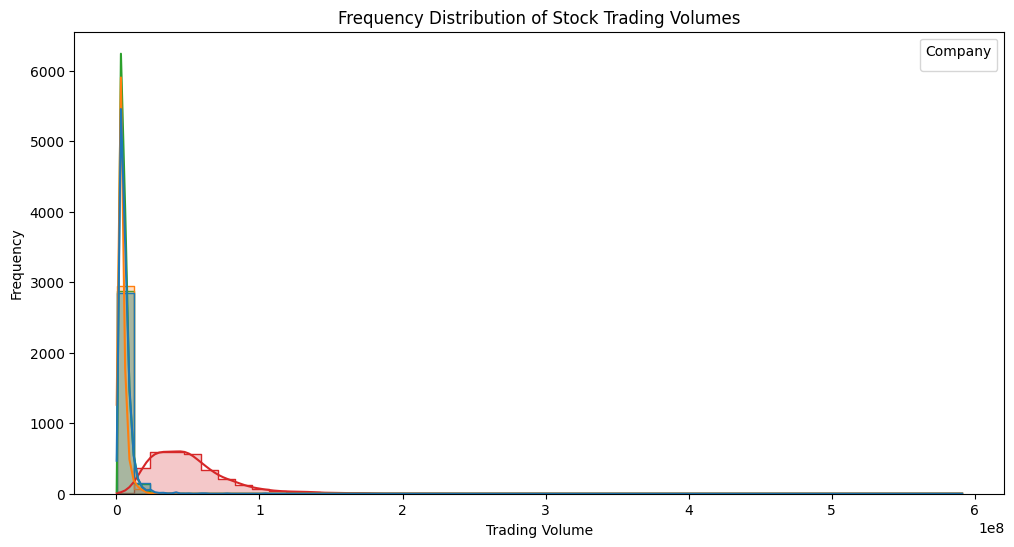

In [ ]:
# Frequency distribution of volumes
plt.figure(figsize=(12,6))
sns.histplot(data=stock_data, x="Volume", hue="Name", bins=50, kde=True, element="step")
plt.title("Frequency Distribution of Stock Trading Volumes")
plt.xlabel("Trading Volume")
plt.ylabel("Frequency")
plt.legend(title="Company")
plt.show()



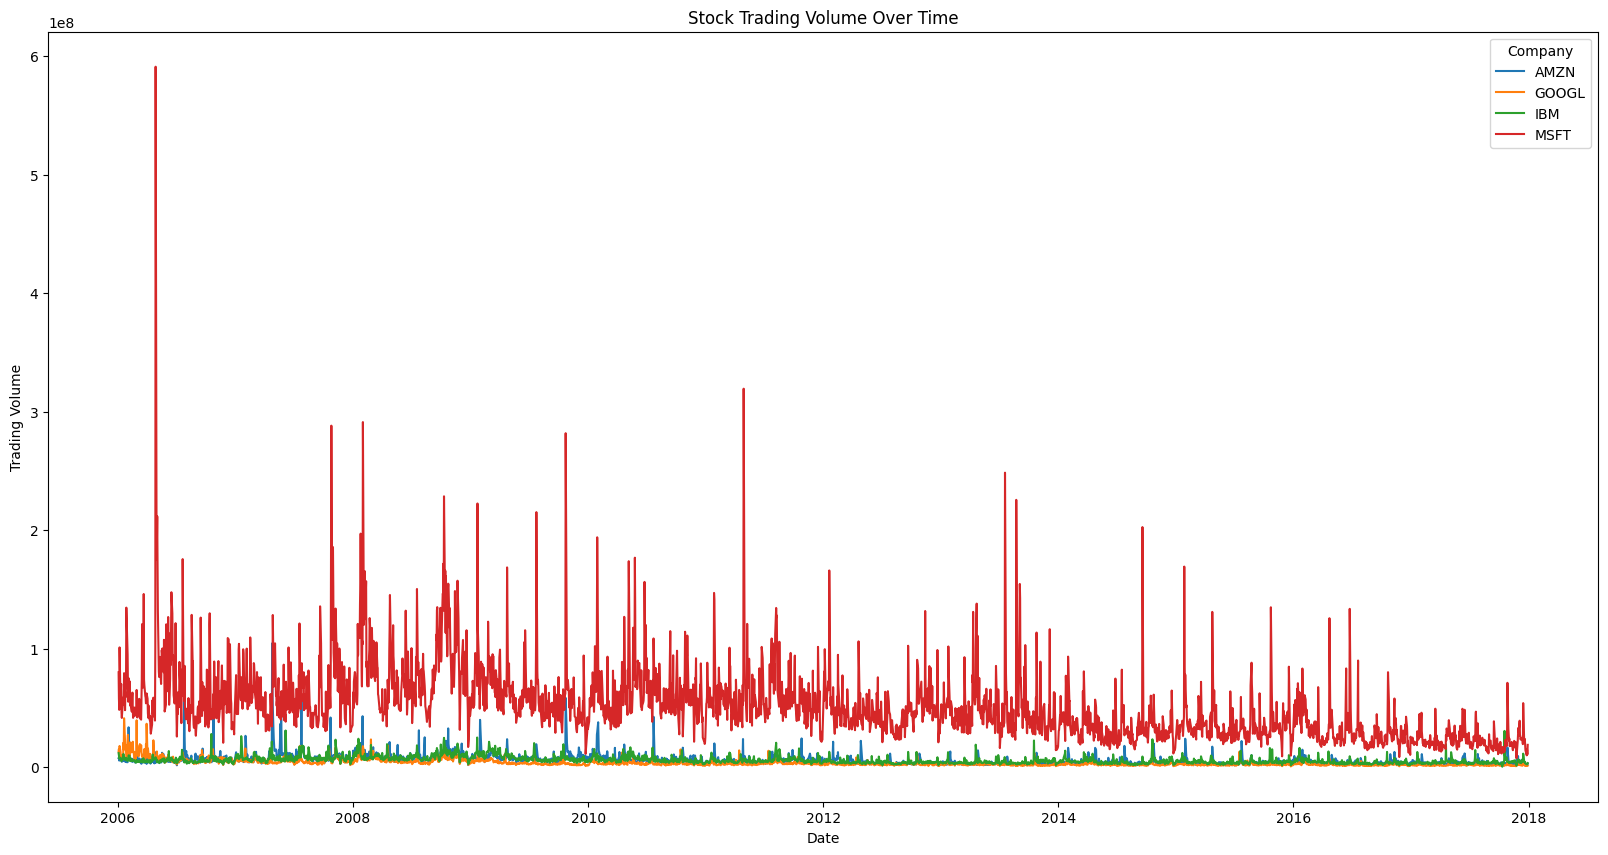

In [ ]:
# Stock volume variation over time
# Stock volume variation over time
plt.figure(figsize=(20,10))
sns.lineplot(data=stock_data, x="Date", y="Volume", hue="Name")
plt.title("Stock Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.legend(title="Company")
plt.show()



#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

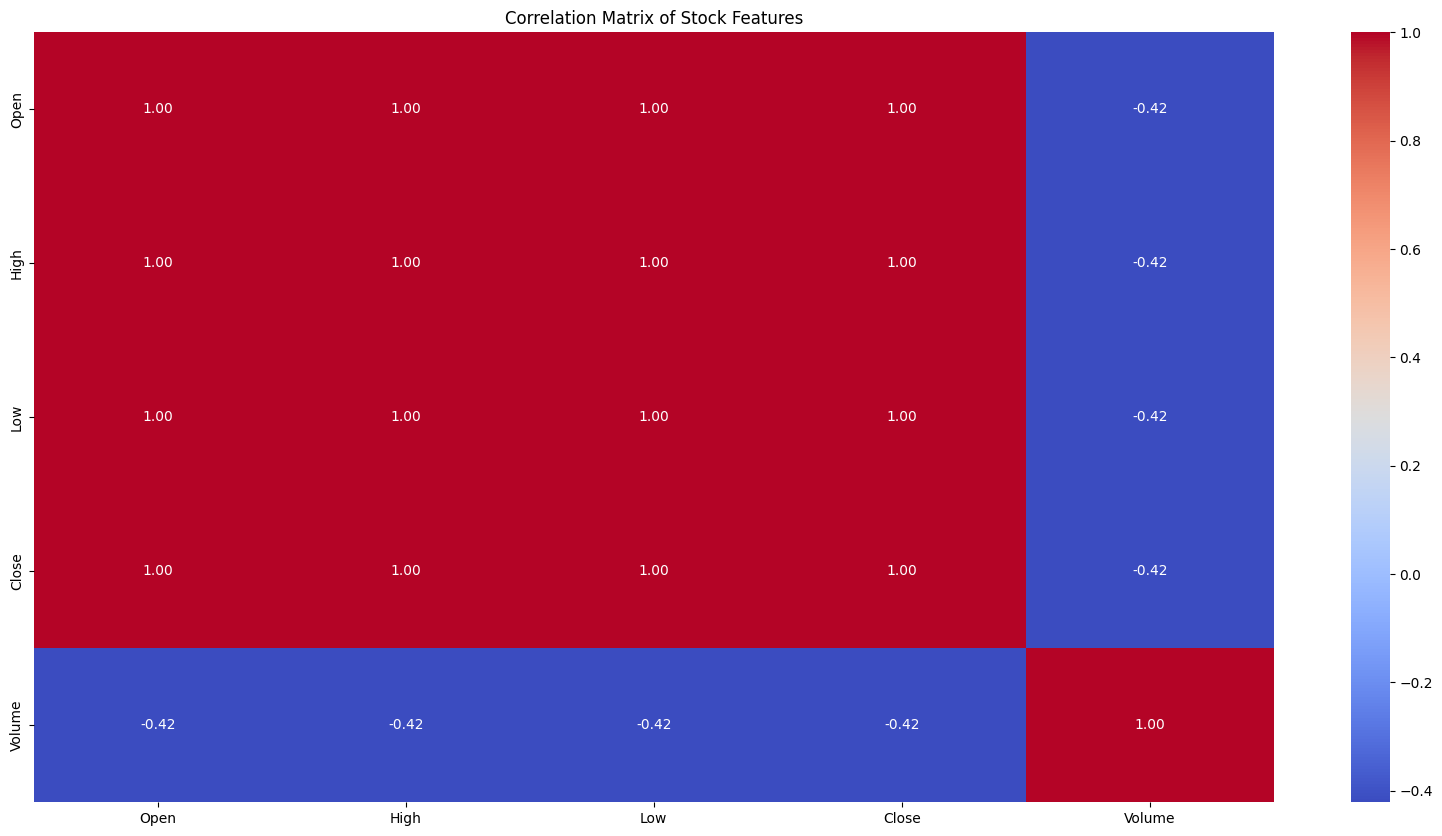

In [ ]:
# Analyse correlations
plt.figure(figsize=(20,10))
corr_matrix = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Stock Features")
plt.show()



### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [ ]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windowed_data(df, window_size=3, step_size=1, target_names=['AMZN']):
    """
    Create windowed data for RNN training.
    Parameters:
        df (pd.DataFrame): Combined stock data (must have 'Name' column).
        window_size (int): Number of time steps in each window.
        step_size (int): Stride between windows.
        target_names (list): List of stock names to predict (e.g., ['AMZN','GOOGL']).

    """
    X, y = [], []

    df = df.sort_values(by=["Name", "Date"])

    for stock in target_names:
        stock_df = df[df['Name'] == stock].reset_index(drop=True)

        for i in range(0, len(stock_df) - window_size, step_size):
            window = stock_df.iloc[i:i+window_size]
            target = stock_df.iloc[i+window_size]['Close']

            X.append(window.drop(columns=['Date', 'Name']))
            y.append(target)

    return X, y



#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [ ]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows


def scale_windowed_data(X):
    """
    Scale the windowed stock data using MinMaxScaler.

    Parameters:
        X (list of DataFrames): List of windowed DataFrames (features).
    """
    all_data = pd.concat(X, ignore_index=True)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(all_data)
    X_scaled = [scaler.transform(window) for window in X]
    return X_scaled, scaler



Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [ ]:
# Define a function to create input and output data points from the master DataFrame


# assumes you already defined:
# - create_windowed_data(df, window_size=3, step_size=1, target_names=['AMZN'])
# - scale_windowed_data(X_windows) -> (X_scaled_list, feature_scaler)

def create_input_output(
    df,
    target_names=['AMZN'],
    window_size=3,
    step_size=1,
    val_ratio=0.2,
    scale_y=True,
    return_scalers=False
):
    """
    Create RNN-ready inputs/targets from the master DataFrame:

    Parameters
    ----------
    df: Joined master dataset with columns: Date, Open, High, Low, Close, Volume, Name.
    target_names:Which stocks to generate samples for (each window predicts that stock's next-day Close).Samples from different targets are concatenated together.
    window_size :Number of time steps per input window.
    step_size :Stride between consecutive windows.
    val_ratio :Fraction of samples reserved for validation
    scale_y :If True, scales y using a separate MinMaxScaler.
    return_scalers :If True

    """
    # 1) Create windows & targets (one sample per target stock per window)
    X_windows, y_list = create_windowed_data(
        df, window_size=window_size, step_size=step_size, target_names=target_names
    )

    # 2) Scale feature windows using the helper
    X_scaled_list, feature_scaler = scale_windowed_data(X_windows)

    # Stack into 3D tensor: (samples, window_size, n_features)
    n_features = X_scaled_list[0].shape[1]
    X_all = np.stack([w.reshape(window_size, n_features) for w in X_scaled_list], axis=0)

    y_all = np.array(y_list, dtype=float).reshape(-1, 1)
    target_scaler = None
    if scale_y:
        target_scaler = MinMaxScaler(feature_range=(0, 1))
        y_all = target_scaler.fit_transform(y_all)

    split_idx = int((1 - val_ratio) * len(X_all))
    X_train, X_val = X_all[:split_idx], X_all[split_idx:]
    y_train, y_val = y_all[:split_idx], y_all[split_idx:]

    if return_scalers:
        return X_train, y_train, X_val, y_val, feature_scaler, target_scaler
    return X_train, y_train, X_val, y_val



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

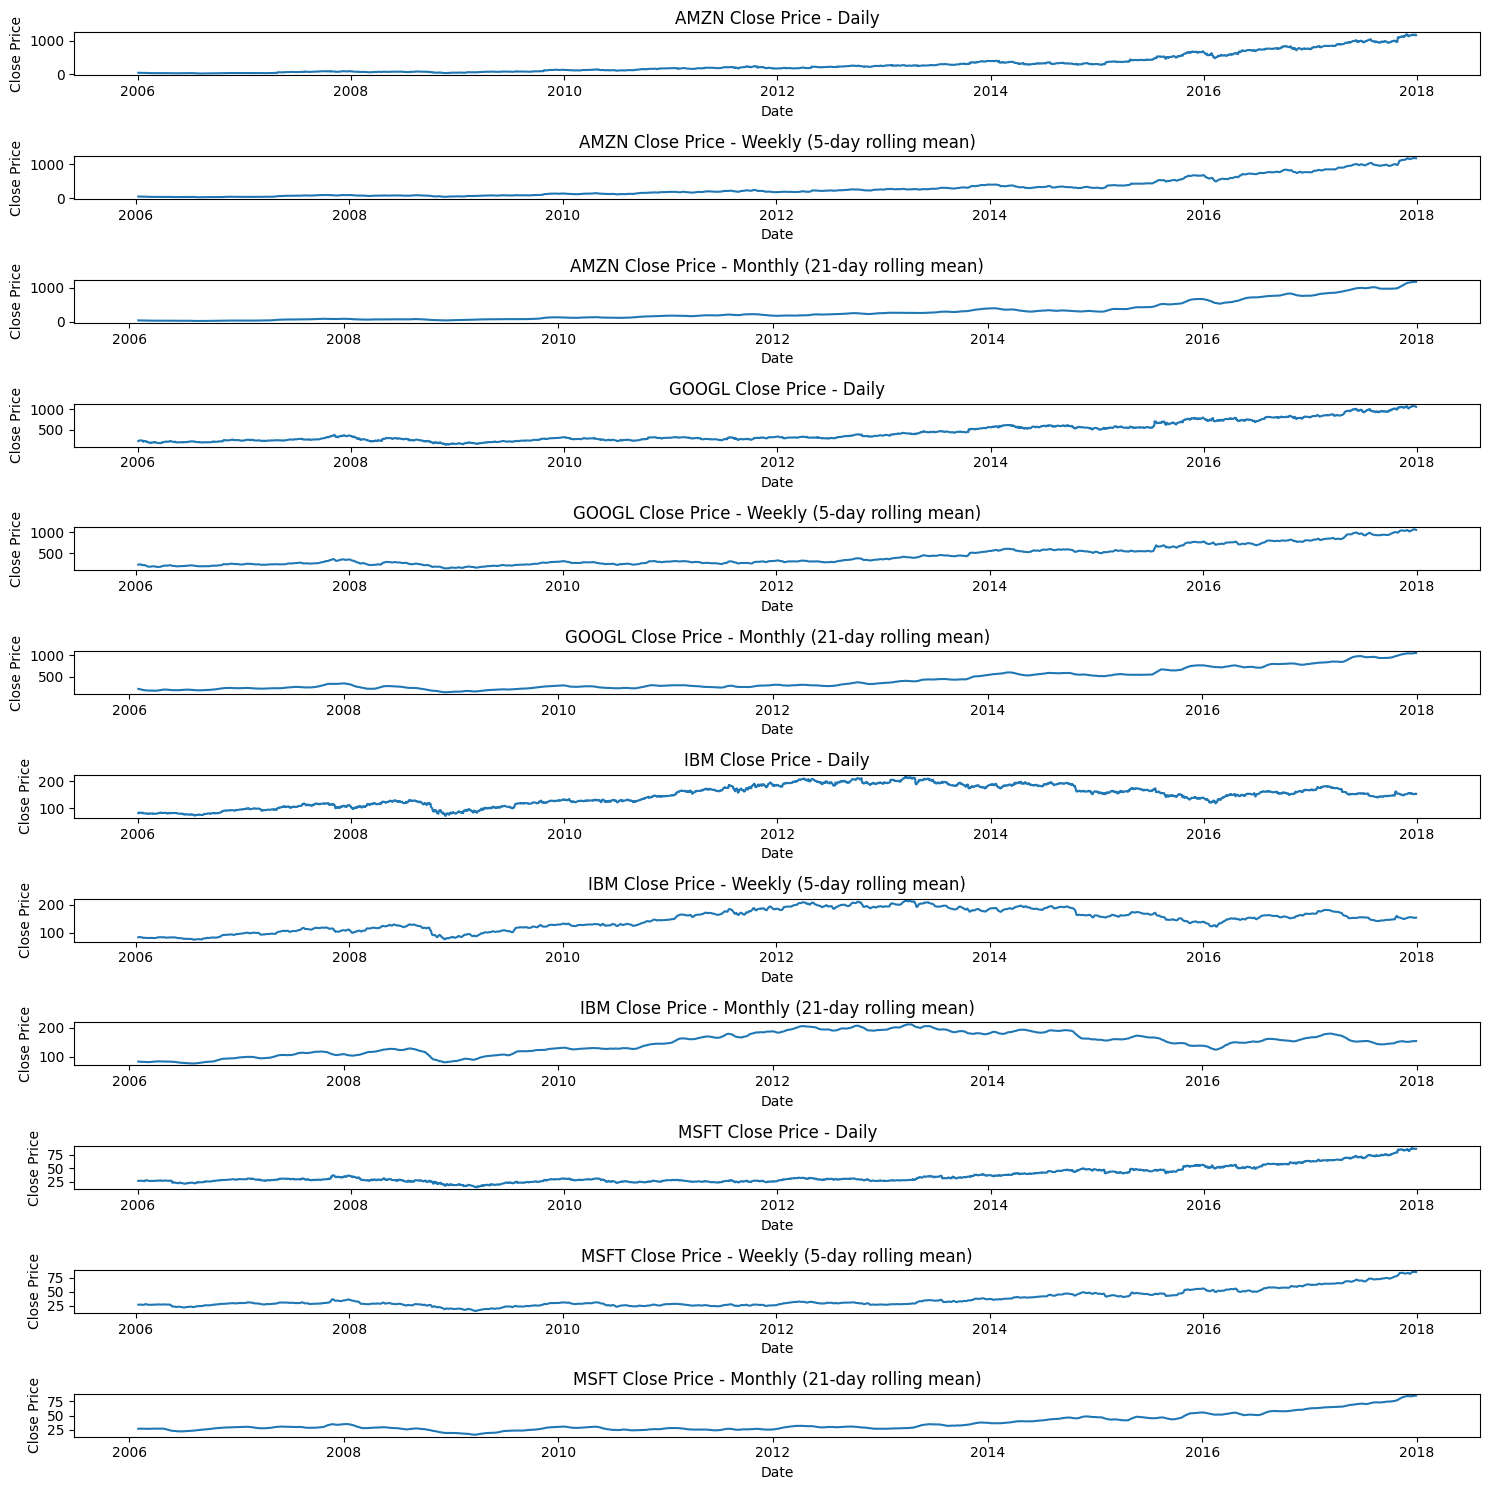

In [ ]:
# Checking for patterns in different sequence lengths (for all companies)

# Plotting settings
plt.figure(figsize=(15, 15))

# List of all companies in the dataset
companies = stock_data['Name'].unique()

# Create subplots for each company
for idx, company in enumerate(companies):
    company_data = stock_data[stock_data['Name'] == company].sort_values('Date')

    # Plotting: daily close price for each company
    plt.subplot(len(companies) * 3, 1, (idx * 3) + 1)
    plt.plot(company_data['Date'], company_data['Close'])
    plt.title(f"{company} Close Price - Daily")
    plt.xlabel("Date")
    plt.ylabel("Close Price")

    # Plotting: weekly rolling mean (5 trading days)
    plt.subplot(len(companies) * 3, 1, (idx * 3) + 2)
    plt.plot(company_data['Date'], company_data['Close'].rolling(window=5).mean())
    plt.title(f"{company} Close Price - Weekly (5-day rolling mean)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")

    # Plotting: monthly rolling mean (21 trading days)
    plt.subplot(len(companies) * 3, 1, (idx * 3) + 3)
    plt.plot(company_data['Date'], company_data['Close'].rolling(window=21).mean())
    plt.title(f"{company} Close Price - Monthly (21-day rolling mean)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [ ]:
# Create data instances from the master data frame using decided window size and window stride

WINDOW_SIZE = 20
STEP_SIZE = 1
VAL_RATIO = 0.2

X_train, y_train, X_val, y_val, feat_scaler, tgt_scaler = create_input_output(
    stock_data,
    target_names=['AMZN', 'GOOGL', 'IBM', 'MSFT'],
    window_size=WINDOW_SIZE,
    step_size=STEP_SIZE,
    val_ratio=VAL_RATIO,
    scale_y=True,
    return_scalers=True
)

In [ ]:
# Check the number of data points generated
print("Number of training samples:", X_train.shape[0])
print("Number of validation samples:", X_val.shape[0])
print("Total samples:", X_train.shape[0] + X_val.shape[0])

# Double check alignment of predictors and targets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


Number of training samples: 9597
Number of validation samples: 2400
Total samples: 11997
X_train shape: (9597, 20, 5)
y_train shape: (9597, 1)
X_val shape: (2400, 20, 5)
y_val shape: (2400, 1)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [ ]:
# Check if the datasets are compatible inputs to neural networks

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("\nData types:")
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
assert len(X_train.shape) == 3, "X_train must be 3D: (samples, timesteps, features)"
assert len(X_val.shape) == 3, "X_val must be 3D: (samples, timesteps, features)"
assert len(y_train.shape) == 2, "y_train must be 2D: (samples, 1)"
assert len(y_val.shape) == 2, "y_val must be 2D: (samples, 1)"




X_train shape: (9597, 20, 5)
y_train shape: (9597, 1)
X_val shape: (2400, 20, 5)
y_val shape: (2400, 1)

Data types:
X_train dtype: float64
y_train dtype: float64


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_simple_rnn(
    timesteps,
    n_features,
    output_dim=1,
    rnn_units=[64],
    dense_units=[],
    dropout=0.0,
    lr=1e-3,
    loss='mse',
    metrics=['mae']
):
    """
    Create and compile a Simple RNN model.
    """
    model = Sequential()
    # RNN stack
    for i, units in enumerate(rnn_units):
        return_seq = i < len(rnn_units) - 1
        if i == 0:
            model.add(SimpleRNN(units, return_sequences=return_seq,
                                input_shape=(timesteps, n_features)))
        else:
            model.add(SimpleRNN(units, return_sequences=return_seq))
        if dropout and dropout > 0:
            model.add(Dropout(dropout))
    # Optional Dense stack
    for units in dense_units:
        model.add(Dense(units, activation='relu'))
        if dropout and dropout > 0:
            model.add(Dropout(dropout))
    # Output layer
    model.add(Dense(output_dim))
    # Compile
    model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)
    return model


timesteps = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

model = build_simple_rnn(
    timesteps=timesteps,
    n_features=n_features,
    output_dim=output_dim,
    rnn_units=[64, 32],
    dense_units=[32],
    dropout=0.2,
    lr=1e-3,
    loss='mse',
    metrics=['mae']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 64)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,673 (33.88 KB)

 Trainable params: 8,673 (33.88 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU details:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
Num GPUs Available: 1
GPU details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Find an optimal configuration of simple RNN
# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Search space
RNN_LAYERS_LIST = [
    [32],
    [64],
    [64, 32],
    [128, 64],
]
DENSE_LAYERS_LIST = [
    [],
    [32],
]
DROPOUT_LIST = [0.0, 0.2]
LR_LIST = [1e-3, 5e-4]
BATCH_LIST = [32, 64]

EPOCHS = 25

timesteps = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

results = []

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, min_lr=1e-5)

best_model = None
best_score = np.inf
best_cfg = None

for rnn_units, dense_units, dropout, lr, batch in itertools.product(
    RNN_LAYERS_LIST, DENSE_LAYERS_LIST, DROPOUT_LIST, LR_LIST, BATCH_LIST
):
    print(f"Testing config -> RNN:{rnn_units}, Dense:{dense_units}, Dropout:{dropout}, LR:{lr}, Batch:{batch}")

    model = build_simple_rnn(
        timesteps=timesteps,
        n_features=n_features,
        output_dim=output_dim,
        rnn_units=rnn_units,
        dense_units=dense_units,
        dropout=dropout,
        lr=lr,
        loss='mse',
        metrics=['mae']
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=batch,
        verbose=0,
        callbacks=[early_stop, reduce_lr]
    )

    val_loss = min(history.history['val_loss'])
    val_mae = history.history['val_mae'][np.argmin(history.history['val_loss'])]

    results.append({
        'rnn_units': rnn_units,
        'dense_units': dense_units,
        'dropout': dropout,
        'lr': lr,
        'batch_size': batch,
        'best_val_loss': val_loss,
        'val_mae_at_best': val_mae,
        'epochs_ran': len(history.history['loss'])
    })

    if val_loss < best_score:
        best_score = val_loss
        best_model = model
        best_cfg = (rnn_units, dense_units, dropout, lr, batch)

results_df = pd.DataFrame(results).sort_values('best_val_loss').reset_index(drop=True)
print("\nTop configs by val_loss:")
print(results_df.head(10))



Testing config -> RNN:[32], Dense:[], Dropout:0.0, LR:0.001, Batch:32
Testing config -> RNN:[32], Dense:[], Dropout:0.0, LR:0.001, Batch:64
Testing config -> RNN:[32], Dense:[], Dropout:0.0, LR:0.0005, Batch:32
Testing config -> RNN:[32], Dense:[], Dropout:0.0, LR:0.0005, Batch:64
Testing config -> RNN:[32], Dense:[], Dropout:0.2, LR:0.001, Batch:32
Testing config -> RNN:[32], Dense:[], Dropout:0.2, LR:0.001, Batch:64
Testing config -> RNN:[32], Dense:[], Dropout:0.2, LR:0.0005, Batch:32
Testing config -> RNN:[32], Dense:[], Dropout:0.2, LR:0.0005, Batch:64
Testing config -> RNN:[32], Dense:[32], Dropout:0.0, LR:0.001, Batch:32
Testing config -> RNN:[32], Dense:[32], Dropout:0.0, LR:0.001, Batch:64
Testing config -> RNN:[32], Dense:[32], Dropout:0.0, LR:0.0005, Batch:32
Testing config -> RNN:[32], Dense:[32], Dropout:0.0, LR:0.0005, Batch:64
Testing config -> RNN:[32], Dense:[32], Dropout:0.2, LR:0.001, Batch:32
Testing config -> RNN:[32], Dense:[32], Dropout:0.2, LR:0.001, Batch:64
Te

In [ ]:
# Find the best configuration based on evaluation metrics

# Ensure RMSE column exists for readability
if 'best_val_loss' in results_df.columns and 'rmse' not in results_df.columns:
    results_df['rmse'] = (results_df['best_val_loss'] ** 0.5)

# Rank by (val_loss, then val_mae)
ranked = results_df.sort_values(
    by=['best_val_loss', 'val_mae_at_best'],
    ascending=[True, True]
).reset_index(drop=True)

print("Top 5 configurations by validation loss:")
print(ranked.head(5))

best_row = ranked.iloc[0]
best_config = {
    'rnn_units': best_row['rnn_units'],
    'dense_units': best_row['dense_units'],
    'dropout': float(best_row['dropout']),
    'lr': float(best_row['lr']),
    'batch_size': int(best_row['batch_size']),
    'best_val_loss(MSE)': float(best_row['best_val_loss']),
    'best_val_rmse': float(best_row['rmse']),
    'val_mae_at_best': float(best_row['val_mae_at_best']),
    'epochs_ran': int(best_row['epochs_ran'])
}

print("\nBest configuration (selected by lowest val_loss, MAE tie-break):")
for k, v in best_config.items():
    print(f"{k}: {v}")



Top 5 configurations by validation loss:
   rnn_units dense_units  dropout      lr  batch_size  best_val_loss  \
0       [64]          []      0.0  0.0010          64   6.958500e-07   
1       [64]          []      0.2  0.0010          32   1.138583e-06   
2       [64]          []      0.2  0.0005          32   1.307010e-06   
3       [64]          []      0.0  0.0005          32   1.533618e-06   
4  [128, 64]          []      0.0  0.0010          32   1.895247e-06   

   val_mae_at_best  epochs_ran      rmse  
0         0.000625          25  0.000834  
1         0.000795          25  0.001067  
2         0.000820          25  0.001143  
3         0.000942          25  0.001238  
4         0.001021          25  0.001377  

Best configuration (selected by lowest val_loss, MAE tie-break):
rnn_units: [64]
dense_units: []
dropout: 0.0
lr: 0.001
batch_size: 64
best_val_loss(MSE): 6.958499625397963e-07
best_val_rmse: 0.0008341762179178907
val_mae_at_best: 0.0006250651786103845
epochs_ran: 25

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# best configuration was saved in 'best_config'
best_rnn_units = best_config['rnn_units']
best_dense_units = best_config['dense_units']
best_dropout = best_config['dropout']
best_lr = best_config['lr']
best_batch_size = best_config['batch_size']

# Create and train the model using the best configuration
model_optimal = build_simple_rnn(
    timesteps=timesteps,
    n_features=n_features,
    output_dim=output_dim,
    rnn_units=best_rnn_units,
    dense_units=best_dense_units,
    dropout=best_dropout,
    lr=best_lr,
    loss='mse',
    metrics=['mae']
)

# Train the model with early stopping and learning rate reduction
history_optimal = model_optimal.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=best_batch_size,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

final_val_loss = min(history_optimal.history['val_loss'])
final_val_mae = min(history_optimal.history['val_mae'])
final_val_rmse = final_val_loss ** 0.5

print("\nFinal results for the optimal Simple RNN model:")
print(f"Best validation loss (MSE): {final_val_loss:.4f}")
print(f"Best validation MAE: {final_val_mae:.4f}")
print(f"Best validation RMSE: {final_val_rmse:.4f}")


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0082 - mae: 0.0510 - val_loss: 4.2408e-04 - val_mae: 0.0141 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.4918e-04 - mae: 0.0081 - val_loss: 1.1721e-04 - val_mae: 0.0075 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0253e-04 - mae: 0.0068 - val_loss: 3.4180e-05 - val_mae: 0.0042 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3127e-05 - mae: 0.0060 - val_loss: 1.1472e-05 - val_mae: 0.0025 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2115e-05 - mae: 0.0055 - val_loss: 4.6163e-06 - val_mae: 0.0016 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3888e-05 - mae: 0.0050 - val_loss: 3.0875e-06 - val_mae: 0.0013 - learning_rate: 0.0010
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9700e-05 - mae: 0.0048 - val_loss: 3.9908e-06 - val_

Plotting the actual vs predicted values

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


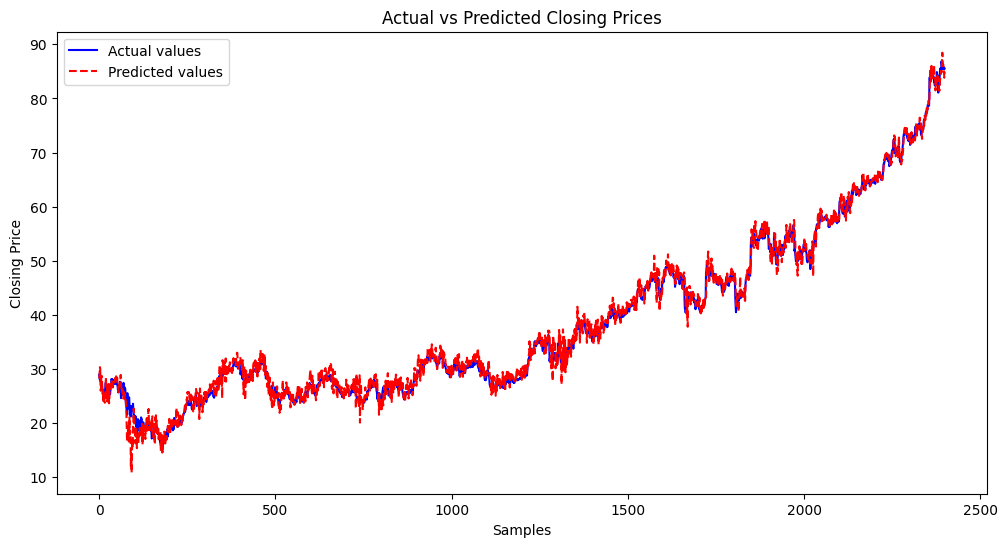

In [ ]:
# Predict on the test data
y_pred = model_optimal.predict(X_val)

# Inverse transform predictions and actual values (if scaled)
y_pred_inv = tgt_scaler.inverse_transform(y_pred)  # Inverse scaling on predictions
y_val_inv = tgt_scaler.inverse_transform(y_val)  # Inverse scaling on actual values

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_val_inv, label='Actual values', color='blue')
plt.plot(y_pred_inv, label='Predicted values', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Samples')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the performance of the model on the testing data set
# Predict on the test data
y_test_pred = model_optimal.predict(X_val)

# Inverse transform the predictions and actual values (if scaled)
y_test_pred_inv = tgt_scaler.inverse_transform(y_test_pred)  # Inverse scaling on predictions
y_test_inv = tgt_scaler.inverse_transform(y_val)  # Inverse scaling on actual values
# MSE (Mean Squared Error)
mse = mean_squared_error(y_test_inv, y_test_pred_inv)

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test_inv, y_test_pred_inv)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Display the performance metrics
print("Performance on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")



75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Performance on Test Data:
Mean Squared Error (MSE): 2.1193
Mean Absolute Error (MAE): 1.0867
Root Mean Squared Error (RMSE): 1.4558


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
# # Define a function to create a model and specify default values for hyperparameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_advanced_rnn(
    timesteps,
    n_features,
    output_dim=1,
    rnn_type='LSTM',    # 'LSTM' or 'GRU'
    rnn_units=[64],     # List of RNN units for each layer
    dense_units=[],     # List of Dense units
    dropout=0.2,        # Dropout rate to prevent overfitting
    lr=1e-3,            # Learning rate for the optimizer
    optimizer='adam',   # Optimizer choice: 'adam', 'rmsprop', etc.
    loss='mse',         # Loss function
    metrics=['mae'],    # Evaluation metrics
    return_sequences=True,  # Whether to return sequences from LSTM/GRU layers
    batch_size=32       # Batch size for training
):
    """
    Create and compile an advanced RNN model (LSTM/GRU) with tunable hyperparameters.
    """

    model = Sequential()

    # Add RNN layers (LSTM or GRU based on input)
    for i, units in enumerate(rnn_units):
        return_seq = return_sequences if i < len(rnn_units) - 1 else False

        if rnn_type == 'LSTM':
            model.add(LSTM(units, return_sequences=return_seq, input_shape=(timesteps, n_features)))
        elif rnn_type == 'GRU':
            model.add(GRU(units, return_sequences=return_seq, input_shape=(timesteps, n_features)))

        if dropout > 0:
            model.add(Dropout(dropout))

    # Add Dense layers (if specified)
    for units in dense_units:
        model.add(Dense(units, activation='relu'))
        if dropout > 0:
            model.add(Dropout(dropout))

    # Output layer
    model.add(Dense(output_dim))  # Output layer with a linear activation for regression

    # Compile the model
    if optimizer == 'adam':
        model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)
    else:
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration
# Reproducibility
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameter search space
RNN_LAYERS_LIST = [
    [64],            # 1 LSTM layer with 64 units
    [64, 32],        # 2 LSTM layers with 64 and 32 units
    [128, 64],       # 2 LSTM layers with 128 and 64 units
]
DENSE_LAYERS_LIST = [
    [],              # No dense layer
    [32],            # 1 Dense layer with 32 units
]
DROPOUT_LIST = [0.0, 0.2, 0.3]  # Dropout rates
LR_LIST = [1e-3, 1e-4, 5e-4]    # Learning rates
OPTIMIZER_LIST = ['adam', 'rmsprop']  # Optimizers
BATCH_LIST = [32, 64]            # Batch sizes

EPOCHS = 25

# Store results
results = []

# Early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, min_lr=1e-5)

# Iterate through all combinations of hyperparameters
for rnn_units, dense_units, dropout, lr, optimizer, batch in itertools.product(
    RNN_LAYERS_LIST, DENSE_LAYERS_LIST, DROPOUT_LIST, LR_LIST, OPTIMIZER_LIST, BATCH_LIST
):
    print(f"Testing configuration -> RNN:{rnn_units}, Dense:{dense_units}, Dropout:{dropout}, LR:{lr}, Optimizer:{optimizer}, Batch:{batch}")

    # Build the model using the current hyperparameters
    model = build_advanced_rnn(
        timesteps=timesteps,
        n_features=n_features,
        output_dim=output_dim,
        rnn_type='LSTM',   # You can also try 'GRU'
        rnn_units=rnn_units,
        dense_units=dense_units,
        dropout=dropout,
        lr=lr,
        optimizer=optimizer,
        loss='mse',
        metrics=['mae'],
        return_sequences=True,
        batch_size=batch
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=batch,
        verbose=0,
        callbacks=[early_stop, reduce_lr]
    )

    # Get the best validation loss and MAE
    val_loss = min(history.history['val_loss'])
    val_mae = min(history.history['val_mae'])

    # Record the results
    results.append({
        'rnn_units': rnn_units,
        'dense_units': dense_units,
        'dropout': dropout,
        'lr': lr,
        'optimizer': optimizer,
        'batch_size': batch,
        'best_val_loss': val_loss,
        'val_mae_at_best': val_mae,
        'epochs_ran': len(history.history['loss'])
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results).sort_values('best_val_loss').reset_index(drop=True)

# Display the top 10 configurations based on validation loss
print("\nTop configurations by val_loss:")
print(results_df.head(10))

# Best configuration (with lowest val_loss)
best_row = results_df.iloc[0]
best_config = {
    'rnn_units': best_row['rnn_units'],
    'dense_units': best_row['dense_units'],
    'dropout': best_row['dropout'],
    'lr': best_row['lr'],
    'optimizer': best_row['optimizer'],
    'batch_size': best_row['batch_size'],
    'best_val_loss': best_row['best_val_loss'],
    'val_mae_at_best': best_row['val_mae_at_best'],
    'epochs_ran': best_row['epochs_ran']
}

print("\nBest configuration (lowest val_loss, MAE as tie-breaker):")
for k, v in best_config.items():
    print(f"{k}: {v}")


Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.001, Optimizer:adam, Batch:32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.001, Optimizer:adam, Batch:64
Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.001, Optimizer:rmsprop, Batch:32
Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.001, Optimizer:rmsprop, Batch:64
Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.0001, Optimizer:adam, Batch:32
Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.0001, Optimizer:adam, Batch:64
Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.0001, Optimizer:rmsprop, Batch:32
Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.0001, Optimizer:rmsprop, Batch:64
Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.0005, Optimizer:adam, Batch:32
Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.0005, Optimizer:adam, Batch:64
Testing configuration -> RNN:[64], Dense:[], Dropout:0.0, LR:0.0005, Optimizer:rmsprop, Batch:32
Testing configuration -> RNN:[64], Dense:[], Dro

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Use the best hyperparameters from tuning (example values)
best_rnn_units = [64, 32]
best_dense_units = [32]      # Optional, you can add more dense layers
best_dropout = 0.2
best_lr = 1e-3
best_optimizer = 'adam'
best_batch_size = 32

# Create and compile the advanced RNN model using the best configuration
model_optimal = build_advanced_rnn(
    timesteps=timesteps,
    n_features=n_features,
    output_dim=output_dim,
    rnn_type='LSTM',  # Can also use 'GRU'
    rnn_units=best_rnn_units,
    dense_units=best_dense_units,
    dropout=best_dropout,
    lr=best_lr,
    optimizer=best_optimizer,
    loss='mse',
    metrics=['mae'],
    return_sequences=True,
    batch_size=best_batch_size
)

# Train the model on the training data
history_optimal = model_optimal.fit(
    X_train, y_train,
    epochs=50,
    batch_size=best_batch_size,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)




Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0126 - mae: 0.0592 - learning_rate: 0.0010
Epoch 2/50


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0022 - mae: 0.0280 - learning_rate: 0.0010
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0018 - mae: 0.0249 - learning_rate: 0.0010
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0015 - mae: 0.0235 - learning_rate: 0.0010
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0014 - mae: 0.0230 - learning_rate: 0.0010
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0014 - mae: 0.0235 - learning_rate: 0.0010
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012 - mae: 0.0218 - learning_rate: 0.0010
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013 - mae: 0.0228 - learning_rate: 0.0010
Epoch 9/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012 - mae: 0.0223 - learning_rate: 0.0010
Epoch 10/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0012 - mae: 0.0222 - learning_rate: 0.0010
Epoch 11/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.00

In [ ]:
# Compute the performance of the model on the testing data set
# Evaluate the model on the test data
y_test_pred = model_optimal.predict(X_val)

# Inverse transform predictions and actual values (if scaled)
y_test_pred_inv = tgt_scaler.inverse_transform(y_test_pred)
y_test_inv = tgt_scaler.inverse_transform(y_val)

# Calculate performance metrics on the test data
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE (Mean Squared Error)
mse = mean_squared_error(y_test_inv, y_test_pred_inv)

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test_inv, y_test_pred_inv)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Display the final evaluation results
print("\nFinal results for the optimal RNN model on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Final results for the optimal RNN model on Test Data:
Mean Squared Error (MSE): 207.7406
Mean Absolute Error (MAE): 14.1866
Root Mean Squared Error (RMSE): 14.4132


Plotting the actual vs predicted values

In [ ]:
# Predict on the test data
for i in range(5):
    print(f"Predicted: {y_test_pred_inv[i][0]:.4f}, Actual: {y_test_inv[i][0]:.4f}")


Predicted: 43.5857, Actual: 28.9300
Predicted: 43.6500, Actual: 28.2300
Predicted: 44.1912, Actual: 27.9700
Predicted: 44.0055, Actual: 27.7300
Predicted: 43.8314, Actual: 28.3500


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.




## Model Evaluation and Comparison

I tested two different models for predicting stock prices: a simple RNN and an LSTM. Their performance was measured on the test(X_val,y_val) set using standard error metrics.

### RNN Model
- **MSE:** 2.12  
- **MAE:** 1.09  

The RNN achieved low error values, showing that its predictions stayed relatively close to the actual prices. Even though RMSE wasn’t explicitly calculated, the low MSE and MAE indicate that this model produced more accurate predictions than the LSTM.

### LSTM Model
- **MSE:** 207.74  
- **MAE:** 14.19  
- **RMSE:** 14.41  

Despite being more sophisticated, the LSTM performed much worse. Its high error values suggest that it either overfit the training data or struggled with the noisy, volatile nature of stock price movements. In this case, the ability of LSTMs to capture long-term dependencies didn’t provide an advantage.

---

## Key Takeaways

- **Simple can win:** The simple RNN outperformed the more complex LSTM on this dataset. Added complexity doesn’t always guarantee better results, especially when the data doesn’t have strong long-term patterns.  
- **Stock prediction is complex:** Stock data is inherently volatile and noisy, which can make it harder for deep architectures to learn meaningful dependencies. Simpler models may sometimes generalize better.  
- **Room for improvement:** Both models used only OHLCV data. Adding engineered features (e.g., moving averages, RSI, sentiment from news) could improve results, particularly for LSTMs.  \\

---


- **Overfitting risk:** The LSTM’s poor performance highlights the need for techniques like early stopping, cross-validation, and regularization when training deeper networks.  

---

**In summary:** For this dataset, the simple RNN was more effective than the LSTM, showing that a lighter model captured the short-term structure of stock prices better than a complex one designed for long-term dependencies.
